# <center>Sequence-to-Sequence Learning with Neural Networks</center>

Throughout this notebook, we will create an **English to French translator**  using a sequence-sequence network.

1. [What is a sequence to sequence network ?](#sec1)


# 1. <a id="sec1"></a>What is a Sequence-to-Sequence model ?

<i>Sequence-to-Sequence</i> (abrv. Seq2Seq) models are deep learning models that take a sequence of items (sentences, medical signals, speech waveforms, time series, …) and output another sequence of items, hence its name "sequence to sequence".

<video width="852" height="480" controls src="Images/seq2seq_1.mp4" />

These models are explained in the two pioneering papers : [Sutskever et al., 2014](http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) and [Cho et al., 2014](http://emnlp2014.org/papers/pdf/EMNLP2014179.pdf).

Sequence to sequence models have proven their effectiveness for many tasks in particular in machine translation, text summarization, image captioning, and speech recognition. 

In the case of Neural Machine Translation, the input is a series of words, and the output is the translated series of words. Until 2014, [Statistical Machine Translation](https://en.wikipedia.org/wiki/Statistical_machine_translation) was by far the most widely studied machine translation method, using statistical models. The introduction of [Neural Machine Translation](https://en.wikipedia.org/wiki/Neural_machine_translation) has significantly increased performance and for instance Google introduced in November 2016 its brand new neural machine translation new [Google Neural Machine Translation](https://en.wikipedia.org/wiki/Google_Neural_Machine_Translation) for Google Translate.

<video width="852" height="480" controls src="Images/seq2seq_mt.mp4" />

# 2. <a id="sec2"></a>How is it made ?

A seq2seq network is made of two neural networks. The first one is a **encoder**, which encodes a variable length input sequence to a fixed-length context vector (we will talk about his context vector later). The second one a **decoder** which receives this context vector and produces the output sequence.

<video width="852" height="480" controls src="Images/seq2seq_2.mp4" />

Note that the input is **3** circles, and the output is **4** triangles. 

Indeed, for tranlation for example, the length of the input sequence in language A is not necessarily equal to the length of the output sequence in language B. "Je suis étudiant" becomes "I am a student". A seq2seq model is able to take a variable-length sequence as an input, and return a variable-length sequence as an output, using a fixed-sized model by encoding many inputs into one vector, and decoding from one vector into many outputs. The seq2seq model frees us from sequence length, which makes it ideal for translation between two languages and opens a whole new range of problems which can now be solved using such architecture.

The encoder and decoder neural networks are generelly **RNNs (Recurrent Neural Networks)**.

### Why do we use RNNs ?

Remember, as we saw with Denis with the Time-series Forecasting notebook, recurrent neural networks depend on the previous state for the current state's computation. Instead of simply prediction $Y = f(x)$ as in feed-forward neural networks, recurrent networks do $Y_1 = f(x_1, f(x_0))$.

<img src="Images/unrolled_rnn.png"/>

You can see that at every point in time, it takes as input its own previous state and the new input at that time step.
<div class="alert alert-success">
RNNs remember their previous state.
</div>

Each state is a function of the previous state, which is the function of its previous state, and so on. So, state n contain information from all past timesteps. And we need this to predict sequences. Indeed, elements in the sequences and the order of these elements have a strong relationship. For instance, a sentence contains words in a certain order and some of which have a strong influence on others. 

For example, let's translate using Google Translate "Je surveille mes actions tous les jours" in english :

<img src="Images/mt_ex_1.png"/>

Now, let's translate "A la bourse, je surveille mes actions tous les jours" :

<img src="Images/mt_ex_2.png"/>

**To recap**, here's a animation showing what we have for a seq2seq machine translation model for the moment.

<video width="852" height="480" controls src="Images/seq2seq_4.mp4" />

In theory, the context vector (the final hidden state of the encoder) will contain semantic information about the query sentence that is input to the bot. 
**Problem**: The context vector is responsible for representing the entire input sequence. The output sequence relies heavily on this vector, making it challenging for the model to deal with long sentences. A solution was proposed in the papers [Bahdanau et al., 2014](https://arxiv.org/pdf/1409.0473.pdf) and [Luong et al., 2015](https://arxiv.org/pdf/1508.04025.pdf) : **attention**.

### Attention

Attention allows the model to focus on the relevant parts of the input sequence at every stage of the output sequence allowing the context to be preserved from beginning to end. 

Instead of sending only one single hidden state vector to the decoder, we send a attention vector created from a linear combination of all previous hidden states.

<video width="852" height="480" controls src="Images/seq2seq_5.mp4" />

For every step the decoder can select a different part of the input sentence to consider. So, every step, a new attention vector (so a new linear combination) is calculated to be relevant for the decoder.

<video width="852" height="480" controls src="Images/seq2seq_6.mp4" />

For an example of the translation of the sentence "L'accord sur la zone économique européènne a été signé en août 1992", we can visualize the attention matrix.

<img width="480" height="360"  src="Images/attention.png"/>

You can see how the model, for unambiguous words like "août" or "1992", gives little importance to the other words in the sentence. You can also see that for "zone économique européenne", the model adapts to the reversed order between French and English.

# 3. <a id="sec3"></a>Let's do our translator

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re, unicodedata
import random

#setting up device for use with pyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device used is ",device)

device used is  cuda


## 3.1. Preprocess the data

In [10]:
data_path = 'datasets/enfratexts.txt'

In [11]:
SOS_token = 0
EOS_token = 1

In [12]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [19]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"\1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


In [20]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [21]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [22]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11449 sentence pairs
Counting words...
Counted words:
fra 5713
eng 3802
['je suis tres satisfait.', 'i am very pleased.']


## 3.2. The model

In [23]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        #Embedding Layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        #GRU Layer
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        #Embedding the input
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [24]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        #Embedding Layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        #GRU layer
        self.gru = nn.GRU(hidden_size, hidden_size)
        #Linear layer mapping to the output size
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        #Embedding the input and applying relu
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        # We feed the embedded vector as well as the context vector passed as argument into the gru
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [25]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p #dropout proba
        self.max_length = max_length
        
        #Embedding layers for the decoder input
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        #First, the input (target sequence) is embedded. Some weights are randomly zeroed out to facilitate
        #learning with the attention mechanism
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        #Attention is computed by combining the context vectors and the embedded input
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        #Attention is applied on the encoded original sentence (in english)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        #We retrieve the embedded input and the context vector (with attention applied), and combine the two tensors
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
        #The attended part of the input is fed into the lstm, conditioned by the hidden and cell states
        output, hidden = self.gru(output, hidden)
        #Retrieve token probabilities
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        #In addition to the output and hidden states that are necessary for iterating, we return the attention
        #weights, that will provide some form of explainability
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 3.3. Functions to Vectorize the training data

In [26]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


## 3.4. Training the model

### 3.4.1. One step training

In [45]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

### 3.4.2. Plotting loss

In [119]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np



def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### 3.4.3. Multiple training iterations

In [127]:
def trainIters(encoder, decoder, n_iters, print_every=100, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("iter = {0} / {1} = {2:.1f}%, loss avg = {3:.2f}".format(iter, n_iters, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### 3.4.4. Training

iter = 100 / 20000 = 0.5%, loss avg = 4.85
iter = 200 / 20000 = 1.0%, loss avg = 3.68
iter = 300 / 20000 = 1.5%, loss avg = 3.68
iter = 400 / 20000 = 2.0%, loss avg = 3.66
iter = 500 / 20000 = 2.5%, loss avg = 3.71
iter = 600 / 20000 = 3.0%, loss avg = 3.61
iter = 700 / 20000 = 3.5%, loss avg = 3.38
iter = 800 / 20000 = 4.0%, loss avg = 3.40
iter = 900 / 20000 = 4.5%, loss avg = 3.19
iter = 1000 / 20000 = 5.0%, loss avg = 3.23
iter = 1100 / 20000 = 5.5%, loss avg = 3.19
iter = 1200 / 20000 = 6.0%, loss avg = 3.18
iter = 1300 / 20000 = 6.5%, loss avg = 3.04
iter = 1400 / 20000 = 7.0%, loss avg = 3.34
iter = 1500 / 20000 = 7.5%, loss avg = 3.10
iter = 1600 / 20000 = 8.0%, loss avg = 3.27
iter = 1700 / 20000 = 8.5%, loss avg = 3.03
iter = 1800 / 20000 = 9.0%, loss avg = 3.20
iter = 1900 / 20000 = 9.5%, loss avg = 3.07
iter = 2000 / 20000 = 10.0%, loss avg = 3.02
iter = 2100 / 20000 = 10.5%, loss avg = 3.16
iter = 2200 / 20000 = 11.0%, loss avg = 2.96
iter = 2300 / 20000 = 11.5%, loss avg 

iter = 18200 / 20000 = 91.0%, loss avg = 1.83
iter = 18300 / 20000 = 91.5%, loss avg = 1.95
iter = 18400 / 20000 = 92.0%, loss avg = 1.91
iter = 18500 / 20000 = 92.5%, loss avg = 2.07
iter = 18600 / 20000 = 93.0%, loss avg = 1.87
iter = 18700 / 20000 = 93.5%, loss avg = 2.05
iter = 18800 / 20000 = 94.0%, loss avg = 2.10
iter = 18900 / 20000 = 94.5%, loss avg = 1.91
iter = 19000 / 20000 = 95.0%, loss avg = 1.89
iter = 19100 / 20000 = 95.5%, loss avg = 1.84
iter = 19200 / 20000 = 96.0%, loss avg = 2.02
iter = 19300 / 20000 = 96.5%, loss avg = 2.10
iter = 19400 / 20000 = 97.0%, loss avg = 1.70
iter = 19500 / 20000 = 97.5%, loss avg = 1.87
iter = 19600 / 20000 = 98.0%, loss avg = 1.82
iter = 19700 / 20000 = 98.5%, loss avg = 1.94
iter = 19800 / 20000 = 99.0%, loss avg = 1.79
iter = 19900 / 20000 = 99.5%, loss avg = 1.88
iter = 20000 / 20000 = 100.0%, loss avg = 1.89


<Figure size 432x288 with 0 Axes>

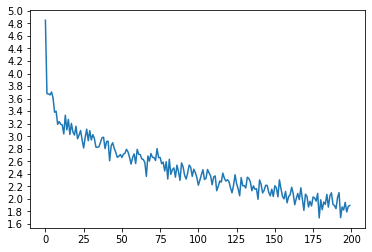

In [128]:
# WATCH OUT ! Set the n_iter parameter, try a small value if you do not have a gpu

hidden_size = 256

n_iter = 15000 # 15000 iters takes 4 minutes on my computer with a gpu

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, n_iter)

### iv - Inference

In [61]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [129]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [130]:
evaluateRandomly(encoder1, attn_decoder1)

> il est le chef du departement de vente.
= he is the head of the sales department.
< he s the the the the <EOS>

> je ne suis pas raciste.
= i m not racist.
< i m not married. <EOS>

> il ne craint pas du tout les serpents.
= he s not at all afraid of snakes.
< he isn not the the the <EOS>

> il n est pas a l interieur.
= he s not in.
< he s not at the <EOS>

> la moisson s annonce bonne cette annee.
= we re expecting a good harvest this year.
< we are going to this this this this <EOS>

> tu es le seul qui puisse m aider.
= you re the only one who can help me.
< you are the one who can help help help help

> vous etes fort craintive.
= you re very timid.
< you re very good. <EOS>

> ils sont nos invites.
= they are our guests.
< they re all good. <EOS>

> je deviens fou.
= i m going crazy.
< i m going to <EOS>

> tu n es rien qu un lache.
= you re nothing but a coward.
< you re not like a child. <EOS>



## d. Plotting the results

**Vizualizing attention**

input = je suis connue.
output = i m thorough. <EOS>
input = elle est trop petit.
output = she s too too <EOS>
input = je ne crains pas de mourir.
output = i m not afraid of <EOS>
input = c est un jeune directeur plein de talent.
output = he s a good <EOS>


/home/matt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


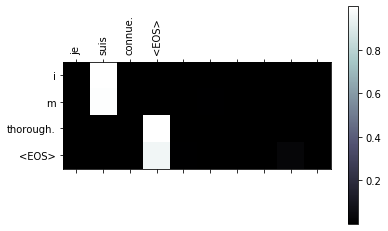

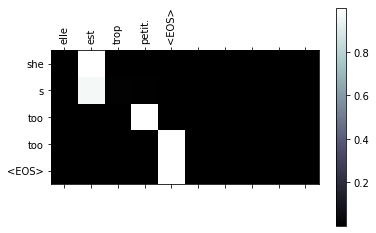

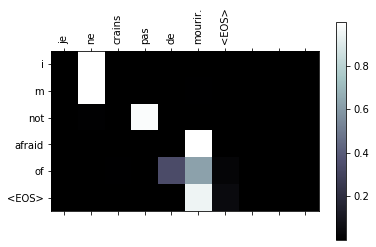

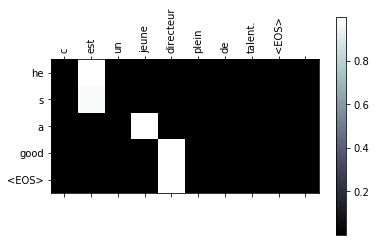

In [131]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("je suis connue.")

evaluateAndShowAttention("elle est trop petit.")

evaluateAndShowAttention("je ne crains pas de mourir.")

evaluateAndShowAttention("c est un jeune directeur plein de talent.")

In [138]:
def evaluateInput(encoder, decoder):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [139]:
evaluateInput(encoder1, attn_decoder1)

> je suis connue.
Bot: i m thorough. <EOS>
> Je
Bot: i m beginning <EOS>
> Salut
Error: Encountered unknown word.
> Bonjour
Error: Encountered unknown word.
> connu
Bot: i am beginning to be a <EOS>
> connue
Bot: you re always <EOS>
> toujours
Bot: we re always to <EOS>
> Comment ça va ?
Bot: i m afraid to be a <EOS>
> Cours !
Bot: you re such <EOS>
> va !
Bot: you re always to <EOS>
> Je lui ai écrit.
Error: Encountered unknown word.
> Je ne sais pas
Bot: i m not your <EOS>
> je ne sais pas.
Bot: i m not telling <EOS>
> je ne sais pas
Bot: i m not your <EOS>
> je ne sais pas ?
Bot: i m not married. <EOS>
> Are you ?
Error: Encountered unknown word.
> You
Error: Encountered unknown word.
> soon
Error: Encountered unknown word.
> son
Bot: he is always on my new <EOS>
> je vais me marrier
Error: Encountered unknown word.
> ok
Error: Encountered unknown word.
> d'accord
Bot: i m beginning to the the <EOS>
> mourir
Bot: i m beginning to be a <EOS>
> mourir
Bot: i m beginning to have the <E

**TO SAY**

Since the task is sequence based, both the encoder and decoder tend to use some form of RNNs, LSTMs, GRUs, etc. 

Despite their flexibility and power, DNNs can only be appliedto problems whose inputs and targetscan be sensibly encoded with vectors of fixed dimensionality. It is a significant limitation, sincemany important problems are best expressed with sequences whose lengths are not known a-priori.For example, speech recognition and machine translation are sequential problems. Likewise, ques-tion answering can also be seen as mapping a sequence of wordsrepresenting the question to a1
sequence of words representing the answer. It is therefore clear that a domain-independent methodthat learns to map sequences to sequences would be useful.Sequences pose a challenge for DNNs because they require that the dimensionality of the inputs andoutputs is known and fixed. 

We use a GRU (Gated Recurrent Units) wich is the subject of one of AML's notebooks this year (topic number 31), if you want to learn more about it.

We will use a bidirectional variant of the GRU, meaning that there are essentially two independent RNNs: one that is fed the input sequence in normal sequential order, and one that is fed the input sequence in reverse order. The outputs of each network are summed at each time step. Using a bidirectional GRU will give us the advantage of encoding both past and future context.

This is important for a chatbot, unlike machine translation. For example, if your input is "Are you a student ?", machine translation can deal with only the past context. 

But you’ll do one trick you might have never seen before. In deep networks like this one, you need to limit extreme gradient change to ensure that the gradient doesn’t change too dramatically, a technique called gradient clipping.